## Deliverable 3: Optimize the Model (20 points)

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf

#  Import and read the charity_data.csv.
application_df = pd.read_csv("../Resources/charity_data.csv")
print(application_df.head()) # preview data
# Drop the EIN and NAME columns.
application_df.drop(labels = ['EIN', 'NAME'], axis = 1, inplace = True) # drop EIN and NAME columns # unused
print(list(application_df.columns))

        EIN                                      NAME APPLICATION_TYPE  \
0  10520599              BLUE KNIGHTS MOTORCYCLE CLUB              T10   
1  10531628    AMERICAN CHESAPEAKE CLUB CHARITABLE TR               T3   
2  10547893        ST CLOUD PROFESSIONAL FIREFIGHTERS               T5   
3  10553066            SOUTHSIDE ATHLETIC ASSOCIATION               T3   
4  10556103  GENETIC RESEARCH INSTITUTE OF THE DESERT               T3   

        AFFILIATION CLASSIFICATION      USE_CASE  ORGANIZATION  STATUS  \
0       Independent          C1000    ProductDev   Association       1   
1       Independent          C2000  Preservation  Co-operative       1   
2  CompanySponsored          C3000    ProductDev   Association       1   
3  CompanySponsored          C2000  Preservation         Trust       1   
4       Independent          C1000     Heathcare         Trust       1   

      INCOME_AMT SPECIAL_CONSIDERATIONS  ASK_AMT  IS_SUCCESSFUL  
0              0                      N     

#### Noisy variables are removed from features (2.5 pt)

In [2]:
# Determine the number of unique values in each column.
# The columns with more than 10 unique values have been grouped together (5 pt)
application_counts = application_df.nunique()
print(f"field unique counts\n{application_counts}\n")

bin_fields = list(application_counts[application_counts > 10].index)
print(f"columns with more than 10 unique values {bin_fields}")

field unique counts
APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

columns with more than 10 unique values ['APPLICATION_TYPE', 'CLASSIFICATION', 'ASK_AMT']


C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64


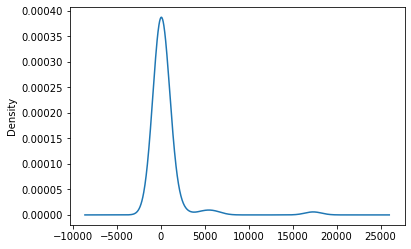

In [3]:
# Determine which values to replace if counts are less than ...?
class_counts = application_df.CLASSIFICATION.value_counts()
print(class_counts)
class_counts.plot.density()
replace_application = list(class_counts[class_counts < 1000].index)

# Replace in dataframe
for app in replace_application:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(app, "Other")

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64


<AxesSubplot:ylabel='Density'>

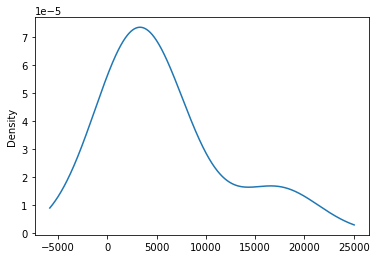

In [4]:
# Check to make sure binning was successful
class_counts = application_df.CLASSIFICATION.value_counts()
print(class_counts)
class_counts.plot.density()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64


<AxesSubplot:ylabel='Density'>

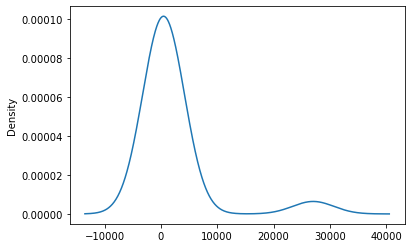

In [5]:
# Determine which values to replace if counts are less than ...?
type_counts = application_df.APPLICATION_TYPE.value_counts()
print(type_counts)
type_counts.plot.density()

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64


<AxesSubplot:ylabel='Density'>

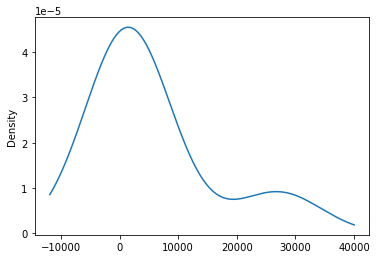

In [6]:
replace_application = list(type_counts[type_counts < 1000].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

# Check to make sure binning was successful
type_counts = application_df.APPLICATION_TYPE.value_counts()
print(type_counts)
type_counts.plot.density()

In [7]:
# custom defined function to bucket/bin data
def lump_income(row):
    income = row['INCOME_AMT']
    updated_income = 0
    if income == '0':
        updated_income = 0
    elif income == '1-9999':
        updated_income = 10000
    elif income == '10000-24999':
        updated_income = 30000
    elif income == '25000-99999':
        updated_income = 100000
    elif income == '100000-499999':
        updated_income = 500000
    elif income == '1M-5M':
        updated_income = 1000000
    elif income == '5M-10M':
        updated_income = 5000000
    elif income == '10M-50M':
        updated_income = 10000000
    elif income == '50M+':
        updated_income = 10000000
    else: 
        updated_income = income
    return updated_income

# custom defined function to bucket/bin ask amounts
def lump_ask(val, intervals):
    for i, boundary in enumerate(intervals):
        if int(val) >= boundary[0] and val < boundary[1]:
            return i
    return 0

5000        25398
10478           3
15583           3
63981           3
6725            3
            ...  
5371754         1
30060           1
43091152        1
18683           1
36500179        1
Name: ASK_AMT, Length: 8747, dtype: int64


<AxesSubplot:ylabel='Density'>

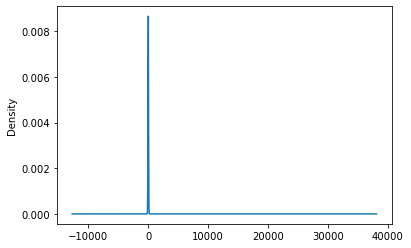

In [8]:
# Determine which values to replace if counts are less than ...?
ask_counts = application_df.ASK_AMT.value_counts()
print(ask_counts)
ask_counts.plot.density()

0     34187
1        33
2        24
3         9
10        7
4         5
6         5
8         5
5         4
11        3
16        3
26        2
12        1
15        1
54        1
20        1
7         1
14        1
39        1
13        1
22        1
19        1
65        1
99        1
Name: ASK_AMT_GROUP, dtype: int64


<AxesSubplot:ylabel='Density'>

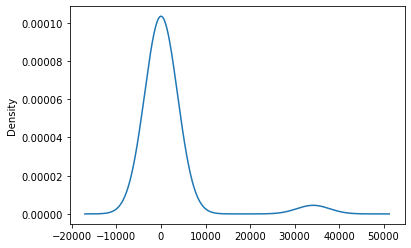

In [9]:
# Replace in dataframe
diff = application_df.ASK_AMT.max() - application_df.ASK_AMT.min()
block_size = int(diff / 100)
intervals = int(diff / block_size)
intervals_list = [(i, (i + 1) * block_size) for i in range(intervals)]
application_df['ASK_AMT_GROUP'] = application_df.ASK_AMT.apply(lambda x: lump_ask(x, intervals_list))
    
# Check to make sure binning was successful
ask_counts = application_df.ASK_AMT_GROUP.value_counts()
print(ask_counts)
ask_counts.plot.density()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64


<AxesSubplot:ylabel='Density'>

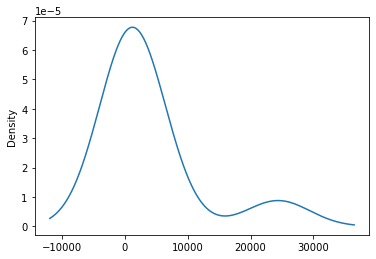

In [10]:
# Determine which values to replace if counts are less than ...?
income_counts = application_df.INCOME_AMT.value_counts()
print(income_counts)
income_counts.plot.density()

0           24388
100000       3747
500000       3374
1000000       955
10000         728
30000         543
10000000      379
5000000       185
Name: INCOME_AMT, dtype: int64


<AxesSubplot:ylabel='Density'>

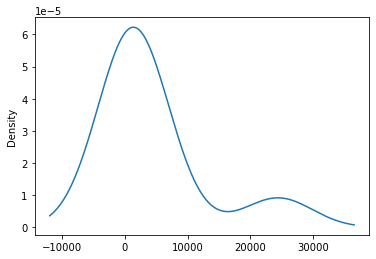

In [11]:
# Replace in dataframe
application_df.INCOME_AMT = application_df.apply(lump_income, axis=1)
    
# Check to make sure binning was successful
income_counts = application_df.INCOME_AMT.value_counts()
print(income_counts)
income_counts.plot.density()

In [12]:
application_df.columns

Index(['APPLICATION_TYPE', 'AFFILIATION', 'CLASSIFICATION', 'USE_CASE',
       'ORGANIZATION', 'STATUS', 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS',
       'ASK_AMT', 'IS_SUCCESSFUL', 'ASK_AMT_GROUP'],
      dtype='object')

In [13]:
# Generate our categorical variable lists
# The categorical variables have been encoded using one-hot encoding (5 pt)
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
y = application_df.IS_SUCCESSFUL
# 'APPLICATION_TYPE', 'AFFILIATION'
#, 'CLASSIFICATION', 'USE_CASE'
#, 'ORGANIZATION', 'STATUS'
#, 'INCOME_AMT', 'SPECIAL_CONSIDERATIONS'
#, 'ASK_AMT', 'IS_SUCCESSFUL']

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat].values))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index = True, right_index = True).drop(labels = application_cat, axis = 1)

# Split our preprocessed data into our features and target arrays
# The preprocessed data is split into features and target arrays (5 pt)

X = application_df

# Split the preprocessed data into a training and testing dataset
# The preprocessed data is split into training and testing datasets (5 pt)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [14]:
# from sklearn.preprocessing import MinMaxScaler
# Create a StandardScaler instances
# The numerical values have been standardized using the StandardScaler() module (5 pt)
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#### Additional neurons are added to hidden layers (2.5 pt)

In [15]:
number_input_features = X_train_scaled.shape[1]
number_input_features

# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
hidden_nodes_layer1 = 100
# hidden_nodes_layer2 = 80
# hidden_nodes_layer3 = 80
hidden_nodes_layer4 = 50
# hidden_nodes_layer5 = 30
# hidden_nodes_layer6 = 30
# hidden_nodes_layer7 = 30
# hidden_nodes_layer8 = 30
hidden_nodes_output = 1

nn_optimized = tf.keras.models.Sequential()

2022-04-12 22:52:06.511566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Additional hidden layers are added (5 pt)
#### The activation function of hidden layers or output layers is changed for optimization (5 pt)

In [16]:
number_input_features

34

In [17]:
# Additional hidden layers are added (5 pt)
# The activation function of hidden layers or output layers is changed for optimization (5 pt)

# # First hidden layer
nn_optimized.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, input_dim = number_input_features, activation = "relu", name = "dense"))

# # Additional hidden layer(s)
# nn_optimized.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, activation = "relu", name = "layer_2"))
# nn_optimized.add(tf.keras.layers.Dense(units = hidden_nodes_layer3, activation = "relu", name = "layer_3"))
nn_optimized.add(tf.keras.layers.Dense(units = hidden_nodes_layer4, activation = "relu", name = "layer_4"))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer5, activation = "relu", name = "layer_5"))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = "relu", name = "layer_6"))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = "relu", name = "layer_7"))
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer6, activation = "relu", name = "layer_8"))

# # Output layer
nn_optimized.add(tf.keras.layers.Dense(units = hidden_nodes_output, activation = "sigmoid", name = "layer_o"))

# # Check the structure of the model
nn_optimized.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3500      
                                                                 
 layer_4 (Dense)             (None, 50)                5050      
                                                                 
 layer_o (Dense)             (None, 1)                 51        
                                                                 
Total params: 8,601
Trainable params: 8,601
Non-trainable params: 0
_________________________________________________________________


#### The model's weights are saved every 5 epochs (2.5 pt)

In [18]:
# Compile the model
nn_optimized.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Train the model
import os
os.makedirs("../Resources/checkpoints/",exist_ok=True)
checkpoint_filepath = "../Resources/checkpoints/opt-weights.{epoch:02d}.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath
    ,save_weights_only = True
    ,verbose = 1
    ,save_freq = 'epoch'
    ,period = 5
)
fit_model = nn_optimized.fit(X_train_scaled, y_train, epochs = 10, callbacks = [checkpoint_callback])

Epoch 1/10
804/804 [==============================] - 3s 3ms/step - loss: 0.0444 - accuracy: 0.9902
Epoch 2/10
804/804 [==============================] - 3s 3ms/step - loss: 0.0036 - accuracy: 0.9993
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 4/10
804/804 [==============================] - 2s 3ms/step - loss: 0.0015 - accuracy: 0.9997
Epoch 5/10
797/804 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9995
Epoch 5: saving model to ../Resources/checkpoints/opt-weights.05.hdf5
804/804 [==============================] - 3s 3ms/step - loss: 0.0036 - accuracy: 0.9995
Epoch 6/10
804/804 [==============================] - 2s 2ms/step - loss: 8.0704e-04 - accuracy: 0.9998
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 7.2428e-04 - accuracy: 0.9998
Epoch 8/10
804/804 [==============================] - 3s 3ms/step - loss: 5.2562e-04 - accuracy: 0.9998
Epoch 9/10
804/804 [=============

#### The results are saved to an HDF5 file (2.5 pt)

In [19]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_optimized.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
nn_optimized.save("AlphabetSoupCharity_Optimzation.h5")

268/268 - 0s - loss: 7.7196e-06 - accuracy: 1.0000 - 404ms/epoch - 2ms/step
Loss: 7.719573659414891e-06, Accuracy: 1.0
